In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import imageio
import json
import time

from collections import Counter
from matplotlib.pyplot import figure
from matplotlib import animation

import concurrent.futures
import multiprocessing

available_cpu=multiprocessing.cpu_count()-1


pdb_list, length_dict, input_features = np.load("datasets/full-input-features.npy",allow_pickle=True)
pdb_list_y, distance_maps_cb = np.load("datasets/full-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)

# these proteins are obsolete (i.e. no longer in the pdb), or just otherwise weird 
# in a dumb way, so we're just gonna remove them

ignore_list=["4osnA0"]

# ignore_list=["1vtz70", 
#              "2cmzA0",
#              '3vdoB0',
#             '3zdkA0',
#             '4bjwB0',
#             '4bkhA0',
#             '4h1bA0',
#             '4hrzA0',
#             '4i4m60',
#             '4lu2A0',       
#             '4rb5C0',
#             '4rb5E0',
#             '4rb5J0',
#             '4rb5N0',
#             '4rb5O0',
#             '4rb5P0',
#             '4rb5T0',
#             '4rb610',
#             '4rb620',
#             '4rb640',
#             '4rb680',
#             '4rb6G0',
#             '4rb6H0',
#             '4rb6I0',
#             '4rb6U0',
#             '4rb6V0',
#             '4rb6X0',
#             '5a41A0',
#             '5ajeA0',
#             "1jniA0",
#             '1vchA0',
#             '1vkbA0',
#             '2vqpA0',
#             '4osnA0',
#             '5by8A0',
#             '4osnA0']

In [2]:
## aaron's code to get raw features from pdb

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
%matplotlib inline
import time
import requests
import xml.etree.ElementTree as ET

# ! pip install biopython
# ! pip install nglview
# ! jupyter-nbextension enable nglview --py --sys-prefix

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

# this is dangerous of course but uncomment it when you want to run the code
# warnings.filterwarnings("ignore")

from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment


In [4]:
# aaron's code to make sure the folders are all in their proper place

dirlocal = os.path.curdir
data_path = os.path.join(dirlocal, 'Data/')
protein_path = os.path.join(data_path, 'Proteins/')
pdb_path = os.path.join(data_path, 'PDB/')
fasta_path = os.path.join(data_path, 'fasta/')
dssp_path = os.path.join(data_path, 'DSSP/')

if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(protein_path):
    os.makedirs(protein_path)
if not os.path.exists(pdb_path):
    os.makedirs(pdb_path)
ss_path = os.path.join(data_path, 'ss.txt')
feature_path = os.path.join(data_path, 'sample-input-features.npy')
distance_path = os.path.join(data_path, 'sample-distance-maps-cb.npy')
full_feature_path = os.path.join(data_path, 'full-input-features.npy')
full_distance_path = os.path.join(data_path, 'full-distance-maps-cb.npy')
test_feature_path = os.path.join(data_path, 'testset-input-features.npy')
test_distance_path = os.path.join(data_path, 'testset-distance-maps-cb.npy')


In [5]:
###  aaron's functions: 

# gets dataframe containing torsion angles, peptides, chain, etc
# from pdb file
def get_torsion_angles(pdb_id, degrees=False):
    pdb_struct = get_pdb_structure(pdb_id)
    torsion_angles = []
    for model in pdb_struct:
        for chain in model:
            polypeptides = PPBuilder().build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                #print("Model %s Chain %s" % (str(model.id), str(chain.id)))
                #print("(part %i of %i)" % (poly_index+1, len(polypeptides)))
                #print("length %i" % (len(poly)))
                #print("from %s%i" % (poly[0].resname, poly[0].id[1]))
                #print("to %s%i" % (poly[-1].resname, poly[-1].id[1]))
                phi_psi = poly.get_phi_psi_list()
                for res_index, residue in enumerate(poly):
                    res_name = "%s%i" % (residue.resname, residue.id[1])
                    #print(res_name, tuple(math.degrees(b) for b in phi_psi[res_index] if b))
                    deg = phi_psi[res_index]
                    if degrees:
                        deg = tuple(math.degrees(b) if b else None for b in deg)
                    phi, psi = deg
                    model_name, model_id = model.full_id
                    torsion_angles.append([model_name, model_id, chain.id, residue.resname, residue.id[1], phi, psi])
    return pd.DataFrame(torsion_angles, columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name', 'Residue_ID', 'Phi', 'Psi'])


# generates ramachandran plot from a given pdb file
def ramachandran_plot(pdb_id, degrees=True):
    df = get_torsion_angles(pdb_id, degrees)
    x = df['Phi']
    y = df['Psi']
    # Generate plot
    plt.plot(x, y, ".")
    plt.title('Ramachandran Plot')
    if degrees:
        plt.xlabel(f'$\Phi$ Angle (Degrees)')
        plt.xlim(-180, 180)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-180, 180)
        plt.show()
    else:
        plt.xlabel(f'$\Phi$ Angle (Radians)')
        plt.xlim(-math.pi, math.pi)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-math.pi, math.pi)
        plt.show()

# helper function which generates a biopython structure
# for display in display_protein()
def get_pdb_structure(pdb_id):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
    try:
        struct = parser.get_structure(pdb_id, file_path)
    except Exception as e:
        print(e)
        return None
    return struct


#  downloads the protein in question from pdb
def get_pdb_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    file_path = os.path.join(pdb_path, f'{pdb_id}.pdb')
    if os.path.isfile(file_path) and not replace:
        return True
    parser = PDBParser()
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    resp = requests.get(url)
    try:
        #print(file_path)
        file = open(file_path, "wb")
        file.write(resp.content)
        file.close()
    except Exception as e: 
        print(e)
        return False
    return True

# neato 3d viewer of a protein's structure
def display_protein(pdb_id):
    pdb_struct = get_pdb_structure(pdb_id)
    view = nv.show_biopython(pdb_struct)
    return view


#  returns a dataframe with secondary structure, amino acid code, chain id, etc
# deprecated
def get_secondary_structure(pdb_id):
    pdb_id = pdb_id.upper()
    indexes = get_pdb_ss_seq(pdb_id)
    chain_df = []
    for i, chain_ss in enumerate(indexes):
        chain_id, seq, ss = chain_ss
        #unknown_list = [i for i, c in enumerate(seq) if c == 'X']
        #print(unknown_list)
        seq_list = [c for c in seq]
        # [f(x) if condition else g(x) for x in sequence]
        ss_list = ['L' if c is ' ' else c for c in ss]
        #print(seq_list + ss_list)
        chain_df.append(pd.DataFrame({'Chain': chain_id, 'Amino_Acid':seq_list, 'Secondary_Structure':ss_list}))
    return pd.concat(chain_df)

# get matrix of pairwise carbon beta distances
def get_cb_distances(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    pdb_struct = get_pdb_structure(pdb_id)  # Returns the BioPython structure of the PDB file
    ppb = PPBuilder()
    chain_dist_matrix = {}
    for model in pdb_struct:
        for chain in model:
            if chain.id == full_pdb_id[4] and partial:
                residues = []
                for pp in ppb.build_peptides(chain, aa_only=False):
                    for residue in pp:
                        residues.append(residue)
                lng = len(residues)
                dist_matrix = np.zeros((lng, lng), np.float)
                for i in range(0, lng):
                    for j in range(i, lng):
                        try:
                            diff_vector  = residues[i]['C'].coord - residues[j]['C'].coord
                        except Exception:
                            # This just gets the average value around the unknown residue distance
                            count = 0
                            sums = 0
                            if j - 1 > 0:
                                count += 1
                                sums += dist_matrix[i][j - 1]
                            if i - 1 > 0:
                                count += 1
                                sums += dist_matrix[i - 1][j]
                            if count > 0:
                                diff_vector = sums / count
                            else:
                                diff_vector = 0
                        dist = np.sqrt(np.sum(diff_vector * diff_vector))
                        dist_matrix[i][j] = dist
                        dist_matrix[j][i] = dist
                    chain_dist_matrix = dist_matrix
        
    if partial:
        start_pos, end_pos, bool_arr = get_seq_pos(full_pdb_id)
        if start_pos == -1:
            return pd.DataFrame(chain_dist_matrix[bool_arr]).iloc[:, bool_arr]
        return pd.DataFrame(chain_dist_matrix[start_pos:end_pos]).iloc[:, start_pos:end_pos]
    else:
        return chain_dist_matrix
    
    
# gets alignment of given sequence on top of the original sequence
# from a fasta file downloaded from the cloud repository
def get_seq_alignment(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = record.seq
    pdb_id = full_pdb_id[0:4].upper()
    #print(pdb_id)
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                alignments = pairwise2.align.globalxx(ground_seq, str(seq))
                al_seq = alignments[0][1]
                al_seq_bool = [False if a is '-' else True for a in al_seq]
                return al_seq_bool

            
def get_seq_pos(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = str(record.seq)
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                start_pos = ground_seq.find(seq)
                if start_pos == -1:
                    alignments = pairwise2.align.globalxx(ground_seq, seq)
                    al_seq = alignments[0][1]
                    bool_seq = [False if a == '-' else True for a in al_seq]
                    #start_pos = largest_substring_pos(ground_seq, seq)
                    #start_pos = int(alignments[0][2] - 1)
                    #end_pos = start_pos + len(al_seq)
                    return (-1, -1, bool_seq)
                else:
                    end_pos = start_pos + len(seq)
                    return (start_pos, end_pos, '')


            
            
# calls dssp api to get dssp file
def pdb_id_to_dssp_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    rest_url = 'http://www.cmbi.umcn.nl/xssp/'
    # Read the pdb id data into a variable
    data = {'data': pdb_id}

    # Send a request to the server to create hssp data from the pdb file data.
    # If an error occurs, an exception is raised and the program exits. If the
    # request is successful, the id of the job running on the server is
    # returned.
    url_create = f'{rest_url}api/create/pdb_id/dssp/'
    r = requests.post(url_create, data=data)
    r.raise_for_status()

    job_id = json.loads(r.text)['id']
    #print(f'Job submitted successfully. Id is: {job_id}')

    # Loop until the job running on the server has finished, either successfully
    # or due to an error.
    ready = False
    while not ready:
        # Check the status of the running job. If an error occurs an exception
        # is raised and the program exits. If the request is successful, the
        # status is returned.
        url_status = f'{rest_url}api/status/pdb_id/dssp/{job_id}/'
        r = requests.get(url_status)
        r.raise_for_status()

        status = json.loads(r.text)['status']
        #print(f'Job status is: {status}')

        # If the status equals SUCCESS, exit out of the loop by changing the
        # condition ready. This causes the code to drop into the `else` block
        # below.
        #
        # If the status equals either FAILURE or REVOKED, an exception is raised
        # containing the error message. The program exits.
        #
        # Otherwise, wait for five seconds and start at the beginning of the
        # loop again.
        if status == 'SUCCESS':
            ready = True
        elif status in ['FAILURE', 'REVOKED']:
            raise Exception(json.loads(r.text)['message'])
        else:
            time.sleep(5)
    else:
        # Requests the result of the job. If an error occurs an exception is
        # raised and the program exits. If the request is successful, the result
        # is returned.
        url_result = f'{rest_url}api/result/pdb_id/dssp/{job_id}/'
        r = requests.get(url_result)
        r.raise_for_status()
        result = json.loads(r.text)['result']
        try:
            file_path = os.path.join(dssp_path, f'{pdb_id}.dssp')
            if os.path.isfile(file_path) and not replace:
                return True
            #print(file_path)
            file = open(file_path, "w")
            file.write(result)
            file.close()
        except Exception as e: 
            print(e)
            return False
        # Return the result to the caller, which prints it to the screen.
        return True

# uses api call file to generate secondary structure, phi/psi, solvent-accessibility stuff
# because of indexing stuff, it crashes if we use partial = True
# ask aaron about that
def get_ground_truth_api(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    struct_info = []
    for model in struct:
        file = os.path.join(pdb_path, f'{pdb_id}.pdb')
        pdb_id_to_dssp_file(pdb_id)
        dssp = DSSP(model=model, in_file=os.path.join(dssp_path, f'{pdb_id}.dssp'), file_type='DSSP')
        seq_count = 0
        #dssp = DSSP(model=model, in_file=file)
        for chain in model:
            if chain.id == full_pdb_id[4] or not partial:
                residues = []
                seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    seq += pp.get_sequence()
                    for residue in pp:
                        residues.append(residue)
                for i, residue in enumerate(residues):
                    try:
                        key = list(dssp.keys())[seq_count]   
                        dssp_info = dssp[key]
                        amino_acid = dssp_info[1]
                        sec_struct = dssp_info[2]
                        solv_acc = dssp_info[3]
                        phi = dssp_info[4]
                        psi = dssp_info[5]
                    except Exception:
                        # DSSP didn't capture this amino acid
                        #print(full_pdb_id, seq_count, len(dssp), len(seq), residue)
                        amino_acid = seq[i]
                        sec_struct = '-'
                        solv_acc = 0
                        phi = 360
                        psi = 360
                    seq_count += 1
                    # Keys 6 through 13 is bonding energy / relidx (no clue what this is)
                    struct_info.append([model.full_id[0], model.full_id[1], chain.id,
                        residue.resname, residue.id[1], amino_acid, sec_struct, solv_acc, phi, psi])
    info_df = pd.DataFrame(struct_info, 
        columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name',
        'Residue_ID', 'Amino_Acid', 'Secondary_Structure', 'Solvent_Accessability', 
        'Phi', 'Psi'])
    if partial:    
        start_pos, end_pos, bool_arr = get_seq_pos(full_pdb_id)
        if start_pos == -1:
            return info_df[bool_arr]
        return info_df[start_pos:end_pos]
    else:
        return info_df


    
# the following two functions download the files from the api
# to create a cache on the disk
# speeds things up immensely, only need to run once though
def get_ground_truth_files(full_pdb_id, replace=False, partial=False):
    bad_list = ['4osnA0']
    if full_pdb_id in bad_list:
        return 'Bad File'
    if partial:
        file_path = os.path.join(protein_path, full_pdb_id + '.csv')
    else:
        file_path = os.path.join(protein_path, full_pdb_id[0:4] + '.csv')
        
    if os.path.isfile(file_path) and not replace:
        return True
    
    df = get_ground_truth(full_pdb_id, partial)
    file_path = ''
    try:
        df.to_csv(file_path)
    except Exception:
        return False
    return True
    
def get_cb_distance_files(full_pdb_id, replace=False, partial=False):
    bad_list = ['4osnA0']
    if full_pdb_id in bad_list:
        return 'Bad File'
    file_path = ''
    if partial:
        file_path = os.path.join(distances_path, full_pdb_id + '.csv')
        if os.path.isfile(file_path) and not replace:
            return True
        try:
            df = get_cb_distances(full_pdb_id, partial)
            df.to_csv(file_path)
        except Exception:
            return False
        return True
    else:
        df = get_cb_distances(full_pdb_id, partial)
        keys = df.keys
        for key in keys:
            file_path = os.path.join(distances_path, full_pdb_id[0:4] + key + '0.csv')
            if os.path.isfile(file_path) and not replace:
                return True
            try:
                df[key].to_csv(file_path)
            except Exception:
                return False
        return True


In [6]:
# this generates the secondary structure ground truth proportions
# for a protein in a certain range(start,stop) of amino acids

def ss_ground_truth(protein_id, aa_range,secs):
    sstructs="HBEGITS"

#     print(aa_range)
#     k=secs[secs['Chain']==protein_id[4]]
    k=secs.iloc[aa_range,:]

    ss_count=[]

    for ss in sstructs:
        ss_count.append(len(k[k['Secondary_Structure']==ss])/len(k))

    return ss_count

# H = alpha helix
# B = residue in isolated beta-bridge
# E = extended strand, participates in beta ladder
# G = 3-helix (3/10 helix)
# I = 5 helix (pi helix)
# T = hydrogen bonded turn
# S = bend


# DON'T USE THIS
# its too intensive to call it over and over again
def format_torsion_angles_to_dataframe(pdb_id, start, chip_size):
    
    get_pdb_file(pdb_id)
    
    angles=[]
    ta=get_torsion_angles(pdb_id)

    angles+=list(ta.iloc[start:start+chip_size,:]["Phi"])
    angles+=list(ta.iloc[start:start+chip_size,:]["Psi"])
    
    return angles

def get_torsion_for_df(pdb_id):
    get_pdb_file(pdb_id)
    return get_torsion_angles(pdb_id)

def distance_map_from_file(pdb_id):
    k= np.genfromtxt(os.path.join("computed_distance_cache",pdb_id+".csv"), delimiter=',',skip_header =1)
    return np.delete(k,0,1)

def get_ground_truth_from_file(pdb_id):
    return pandas.read_csv(os.path.join("computed_ground_truth_cache",pdb_id.upper()+".csv"))

In [16]:
#define functions

# mean function
# just for utility purposes
def mean(numlist):
    return sum(numlist)/len(numlist)

# this creates triangular chips along (but not including)
# the diagonal within the comparison matrix
def chip_diagonal(chip_size, step_size, aa_length):
    tri=[]
    for diag in range(0,aa_length-chip_size,step_size):
        tri.append(
            [(y,x) for y in range(diag,diag+chip_size) for x in range(y+1,chip_size+diag+1)]
        )
        # NB: y already has diag added to it
    return tri


def make_chip(chip_size):
    return [(y,x) for y in range(0,chip_size) for x in range(y+1,chip_size+1)]

# create a gif showing where the triangular chipping window is located
def gif_from_tri(protein_id,tri,filename):
    
    protein = np.array(distance_maps_cb[protein_id])
    l=len(protein)

    gif=[]

    for t in tri:
        new_test=np.ones((l,l))*0
        for (y,x) in t:
            new_test[y,x]=protein[y,x]

        im=plt.imshow(new_test)

        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=5)


# create a dataframe from a given protein id, chip size, and step size
def diag_chips_to_df(protein_id, chip_size, step_size, chip=None, off_diag=False):
    
    # arrange all the feature matrices into proper form so we can 
    # reference them properly later
        
#         cb_dist_cache
    test_distmap=distance_map_from_file(protein_id)
    if test_distmap is not None:
        protein_dist=test_distmap
    elif (protein_id + ".csv" in os.listdir("./cb_dist_cache")):
        protein_dist=pandas.read_csv(os.path.join("cb_dist_cache",(protein_id + ".csv")))
    else:
        protein_dist = np.array(get_cb_distances(protein_id,partial=True))
    
    aa_length=protein_dist.shape[0]
#     print(aa_length)
    
    protein_feat = np.array(input_features[protein_id])

    feat_len=protein_feat[0].shape[0]
    pad_len=aa_length-feat_len
    
    if pad_len<0:
        print("ERROR: NEGATIVE PAD LENGTH FOR "+ protein_id)
        print("AA_LEN: "+str(aa_length))
        print("FEAT_LEN: "+str(feat_len))
    
    ccmpred=protein_feat[5].astype(np.float)
    ccmpred.shape=(feat_len,feat_len)
    ccmpred=np.pad(ccmpred,pad_len,'constant', constant_values=(0))
    
    freecontact=protein_feat[6].astype(np.float)
    freecontact.shape=(feat_len,feat_len)
    freecontact=np.pad(freecontact,pad_len,'constant', constant_values=(0))
    
    pstat_pots=protein_feat[7].astype(np.float)
    pstat_pots.shape=(feat_len,feat_len)
    pstat_pots=np.pad(pstat_pots,pad_len,'constant', constant_values=(0))
    
    if chip==None:
        chip=make_chip(chip_size)
        
    if off_diag:
        chip_offsets=[(i,j) for i in range(0,aa_length-chip_size,step_size) for j in range(0,aa_length-chip_size,step_size)]
    else:
        chip_offsets=[(d,d) for d in range(0,aa_length-chip_size,step_size)]

    chips=[[tuple(sum(t) for t in zip(a,(d,d))) for a in chip] for d in range(0,aa_length-chip_size,step_size)]
    
    print(protein_id)
    
# check ground_truth_cache
    test_gt=get_ground_truth_from_file(protein_id)
    if(test_gt is not None):
        gt=test_gt
    elif (protein_id.upper() + ".csv" in os.listdir("./ground_truth_cache")):
        gt=pandas.read_csv(os.path.join("ground_truth_cache",(protein_id.upper() + ".csv")))
    else:
        gt=get_ground_truth_api(protein_id,partial=True) # set to inverse
    
    # create column labels
    cols=["protein_id","chip_id"]
    cols+=["starty","stopy"]
    cols+=["startx","stopx"]
    cols+=["dist_"+str(n) for n in range(0,len(chips[0]))]
    cols+=["psipred_helix","psipred_sheet","psipred_coil"]
    cols+=["psisolv","shannon_entropy"]
    cols+=["ccmpred","freecontact","pstat_pots"]
    cols+=["ground_truth_"+x for x in "HBEGITS"]
    cols+=["phi_"+str(x) for x in range(0,chip_size)]
    cols+=["psi_"+str(x) for x in range(0,chip_size)]
    cols+=["solv_access_"+str(x) for x in range(0,chip_size)]

    
    chiplist=[]
    
    t_phi=list(gt['Phi'])
    t_psi=list(gt['Psi'])
    t_solv=list(gt['Solvent_Accessability'])
    
    # loop through all the chips
    for i in range(0,len(chips)):
        
        # row identifiers
        row=[protein_id,"chip_"+str(i)]
        
        # start and stop, hope this fixes them
        # starty, stopy
        row+=[
            min([c[0] for c in chips[i]]),
            max([c[0] for c in chips[i]])
        ]
        # startx, stopx
        row+=[
            min([c[1] for c in chips[i]]),
            max([c[1] for c in chips[i]])
        ]
        
        # inclusion range
        # between the first amino acid being compared 
        # and the last amino acid being compared
        # NB this assumes that 
        incl_range=range(min(min(chips[i])),max(max(chips[i])))
        
        # 1d features
        base_helix=protein_feat[0].astype(np.float)
        base_sheet=protein_feat[1].astype(np.float)
        base_coil=protein_feat[2].astype(np.float)
        base_solv=protein_feat[3].astype(np.float)
        base_shan=protein_feat[4].astype(np.float)
        
        base_helix=np.pad(base_helix,pad_len,'constant', constant_values=(0))
        base_sheet=np.pad(base_sheet,pad_len,'constant', constant_values=(0))
        base_coil=np.pad(base_coil,pad_len,'constant', constant_values=(0))
        base_solv=np.pad(base_solv,pad_len,'constant', constant_values=(0))
        base_shan=np.pad(base_shan,pad_len,'constant', constant_values=(0))
        
        psipred_helix=mean(base_helix[incl_range])
        psipred_sheet=mean(base_sheet[incl_range])
        psipred_coil=mean(base_coil[incl_range])
        psisolv=mean(base_solv[incl_range])
        shannon_entropy=mean(base_shan[incl_range])
        
        
        
        # 2d features
        ccmpred_pool=[]
        freecontact_pool=[]
        pstat_pool=[]
        
        # ss ground truth
        ssgt=ss_ground_truth(protein_id,incl_range,gt)
        
        # loop through each pixel in the chip
        for n in range(0,len(chips[i])):
            
#             make sure we're not on the diagonal
#             print([chips[i][n][0],chips[i][n][1]])
            
            row.append(
                protein_dist[chips[i][n][0],chips[i][n][1]]
            )
            ccmpred_pool.append(
                ccmpred[chips[i][n][0],chips[i][n][1]]
            )
            freecontact_pool.append(
                freecontact[chips[i][n][0],chips[i][n][1]]
            )
            pstat_pool.append(
                pstat_pots[chips[i][n][0],chips[i][n][1]]
            )
            
        # 1d features
        row.append(psipred_helix)
        row.append(psipred_sheet)
        row.append(psipred_coil)
        row.append(psisolv)
        row.append(shannon_entropy)
   
        # 2d features
        row.append(max(ccmpred_pool))
        row.append(max(freecontact_pool))
        row.append(max(pstat_pool))
        
        # ground truth
        [row.append(x) for x in ssgt]
        
        # torsional angles
        row+=t_phi[i:i+chip_size]
        row+=t_psi[i:i+chip_size]
        row+=t_solv[i:i+chip_size]
#         print(row)
        
        # add to df
        chiplist.append(row)

    chip_df=pandas.DataFrame(chiplist,columns=cols)

    return chip_df


# compute the ground truth secondary structure
# of which the majority of amino acids in a window
# are a part of
# i.e. that whose percentage within the window is above 50%
def compute_majority_ss(df):
    for ss in "HBEGITS":
        df["maj_"+ss]=int(df['ground_truth_'+ss]>.5)
    return df

def ss_categorical(df):
    df["ss_majority_categorical"]="None"
    for ss in "HBEGITS":
        df.loc[df['ground_truth_'+ss]>.5,"ss_majority_categorical"]=ss
    return df

In [ ]:
# def chipped aa seq

# def chipped_aa_seq(protein_id, start, chip_size):
    

In [15]:
# dataset=pandas.read_csv(os.path.join("datasets","protein_all_5.csv")).dropna()


In [20]:
# dataset[dataset['ground_truth_H']>.5]["protein_id"]
# dataset["x"]=1
# ss_categorical(dataset)

,Unnamed: 0,protein_id,chip_id,start,stop,dist_0,dist_1,dist_2,dist_3,dist_4,...,solv_access_3,solv_access_4,maj_H,maj_B,maj_E,maj_G,maj_I,maj_T,maj_S,ss_majority_categorical
0,0,12asA0,chip_0,0,5,2.931498,4.466173,4.830971,5.929355,8.004140,...,0.462264,0.112195,True,False,False,False,False,False,False,H
1,1,12asA0,chip_1,1,6,2.977764,4.556571,4.825561,5.993463,8.187191,...,0.112195,0.000000,True,False,False,False,False,False,False,H
2,2,12asA0,chip_2,2,7,3.011051,4.573128,4.944533,6.271376,8.255353,...,0.000000,0.508065,True,False,False,False,False,False,False,H
3,3,12asA0,chip_3,3,8,3.055943,4.643566,4.900433,6.196664,8.368240,...,0.508065,0.227273,True,False,False,False,False,False,False,H
4,4,12asA0,chip_4,4,9,3.033617,4.514310,4.787584,6.232026,8.312329,...,0.227273,0.000000,True,False,False,False,False,False,False,H
5,5,12asA0,chip_5,5,10,3.223323,4.594050,5.066024,6.347551,8.505913,...,0.000000,0.230769,True,False,False,False,False,False,False,H
6,6,12asA0,chip_6,6,11,2.976352,4.657997,5.042452,6.315280,8.412719,...,0.230769,0.279188,True,False,False,False,False,False,False,H
7,7,12asA0,chip_7,7,12,2.983589,4.640706,5.149854,6.408232,8.367692,...,0.279188,0.000000,True,False,False,False,False,False,False,H
8,8,12asA0,chip_8,8,13,3.081327,4.675354,5.066069,6.178646,8.111391,...,0.000000,0.136585,True,False,False,False,False,False,False,H
9,9,12asA0,chip_9,9,14,3.076244,4.648451,5.031323,5.955137,8.097498,...,0.136585,0.615385,True,False,False,False,False,False,False,H


In [17]:
# this is the thing
# this makes the whole dataset
# these three lines below
# just run these and it'll make the dataset

chip_size=25
stride=10

chip=make_chip(chip_size)

dataset=pandas.concat([(diag_chips_to_df(pid,chip_size,stride,chip,off_diag=True)) for pid in [x for x in pdb_list_y if x not in ignore_list]])
dataset=dataset.dropna()
ss_categorical(dataset)
dataset.to_csv("datasets/protein_all_25.csv")


12asA0
16pkA0
16vpA0
1a0tP0
1a2zA0
1a8rA0
1ahsA0
1aihA0
1aisB0
1am9A0
1aocA0
1aolA0
1at0A0
1au1A0
1b33N0
1b35A0
1b35B0
1b3tA0
1b67A0
1b77A0
1b9wA0
1bd3A0
1bgfA0
1bndA0
1bouA0
1bx7A0
1bxyA0
1byrA0
1c0pA0
1c1kA0
1c5eA0
1c8zA0
1cbfA0
1cbkA0
1cfzA0
1cjcA0
1cl8A0
1cmcA0
1cq3A0
1cseI0
1cshA0
1cxzB0
1d02A0
1d2pA0
1d2zA0
1d2zB0
1d9cA0
1dbfA0
1dcqA0
1ddzA0
1dfmA0
1dfuP0
1dhnA0
1di2A0
1dj0A0
1dj8A0
1dm9A0
1dmhA0
1dmuA0
1dp4A0
1dq3A0
1dqnA0
1dtdB0
1dvkA0
1dvoA0
1dwkA0
1dx5I0
1dzfA0
1e0bA0
1eaiC0
1eaqA0
1eayC0
1ecmA0
1ecsA0
1ed1A0
1edyA0
1eerA0
1efuD0
1ei7A0
1ejbA0
1ejfA0
1ek9A0
1el6A0
1em2A0
1em9A0
1eteA0
1evsA0
1ezgA0
1f08A0
1f0kA0
1f1eA0
1f2dA0
1f32A0
1f35A0
1f3mA0
1f3uA0
1f3vA0
1f46A0
1f5qB0
1f60B0
1f94A0
1fasA0
1fc3A0
1feuA0
1fi4A0
1fiuA0
1fjrA0
1fkmA0
1fn9A0
1fp3A0
1fpzA0
1fr3A0
1fsgA0
1ft5A0
1fx3A0
1fxkC0
1fzvA0
1g31A0
1g5zA0
1g61A0
1g6gA0
1g8eA0
1g8lA0
1gakA0
1gd8A0
1gflB0
1gl4A0
1gmuA0
1gotG0
1gprA0
1gqaA0
1gqeA0
1gs9A0
1gsaA0
1gu9A0
1guqA0
1gxmA0
1gxyA0
1gyxA0
1gzsB0
1h12A0
1h21A0
1h2sB0

2pd1A0
2pfmA0
2pfxA0
2pgcA0
2ph0A0
2phnA0
2phpA0
2pieA0
2pihA0
2pijA0
2pjsA0
2pjuA0
2pk8A0
2pkhA0
2pliA0
2pn1A0
2pn2A0
2pnlA0
2po1B0
2pofA0
2porA0
2posA0
2ppvA0
2ppxA0
2pqcA0
2pr7A0
2prvA0
2ps5A0
2psmA0
2pspA0
2pstX0
2pt7G0
2pv4A0
2pwwA0
2py8A0
2pyqA0
2pywA0
2q03A0
2q0oC0
2q0tA0
2q14A0
2q2gA0
2q5cA0
2q5wE0
2q6qA0
2q73A0
2q8oA0
2q8vA0
2q97T0
2qasA0
2qb7A0
2qc5A0
2qdlA0
2qebA0
2qeuA0
2qffA0
2qg3A0
2qhfA0
2qipA0
2qjyA0
2qklB0
2ql2B0
2ql8A0
2qlcA0
2qltA0
2qlwA0
2qm4A0
2qn6B0
2qndA0
2qnlA0
2qpvA0
2qpwA0
2qqyA0
2qqzA0
2qsaA0
2qsfX0
2qskA0
2qswA0
2qtsA0
2qudA0
2qyaA0
2qycA0
2qywA0
2qz7A0
2qzgA0
2qziA0
2r0yA0
2r18A0
2r1fA0
2r1jL0
2r4fA0
2r5uA0
2r60A0
2r6iA0
2r6uA0
2rbbA0
2rbdA0
2rckA0
2rd9A0
2rdcA0
2re3A0
2retA0
2rffA0
2rh0A0
2rh3A0
2rhkC0
2rjiA0
2rjzA0
2rk0A0
2rk5A0
2rklA0
2tgiA0
2uvpA0
2uw1A0
2uwjE0
2v3sA0
2v4xA0
2v7qH0
2v7sA0
2v8qA0
2v8qE0
2v8tA0
2vfkA0
2vfrA0
2vg3A0
2vgaA0
2vj4A0
2vjeB0
2vkjA0
2vklA0
2vn6B0
2vqgA0
2vqpA0
2vveA0
2vvfA0
2vvwA0
2w0gA0
2w1jA0
2w2uA0
2w5qA0
2w6kA0
2w7aA0
2w7qA0

3ufcX0
3ufeA0
3ufiA0
3ugoA0
3uidA0
3uipD0
3uitA0
3uk3C0
3ulhA0
3ultA0
3uo3A0
3uq8A0
3uqcA0
3utkA0
3uunA0
3uv0A0
3uxjA0
3v0rA0
3v33A0
3v4kA0
3v5wG0
3v68A0
3v69A0
3v6iB0
3v7bA0
3v9rA0
3va4A0
3va9A0
3vajA0
3vasA0
3vbcA0
3vbhA0
3vbhC0
3vbhD0
3vbjA0
3vc8A0
3vdjA0
3vdoB0
3veaA0
3vg8A0
3vgzA0
3vh5A0
3vhjA0
3vivA0
3vjfA0
3vk0A0
3vk6A0
3vk8A0
3vl1A0
3vorA0
3vpbA0
3vpyA0
3vqjA0
3vr0A0
3vrdB0
3vsjB0
3vtoA0
3vy8X0
3vygB0
3vygC0
3vyxA0
3vz9B0
3vz9D0
3w0eA0
3w0oA0
3w0tA0
3w1oA0
3w1zA0
3w36A0
3w42A0
3w4sA0
3w54A0
3w61A0
3w8hB0
3wasA0
3wb0A0
3wcaA0
3wdgB0
3wfdB0
3whrA0
3wisA0
3wjtA0
3wkgA0
3wmqA0
3wnzA0
3wo6A0
3woeB0
3wqbB0
3wrbA0
3wscA0
3wu2A0
3wu2E0
3wu2H0
3wu2Z0
3wurA0
3wv7A0
3wvaA0
3wvqA0
3ww9A0
3wwtB0
3wx4A0
3x0uA0
3x2mA0
3x37A0
3x37B0
3x38A0
3zbdA0
3zbgA0
3zdkA0
3zdmA0
3ze3A0
3zfiA0
3zfpA0
3zghA0
3zhiA0
3zieA0
3zigA0
3zihA0
3zjaA0
3zk9A0
3zleA0
3zn4A0
3znuA0
3zpnA0
3zqoA0
3zqsA0
3zr8X0
3zrgA0
3zrxA0
3zsuA0
3zuxA0
3zvkA0
3zvkE0
3zw5A0
3zzhA0
3zzlA0
3zzoA0
3zzyA0
4a0eA0
4a0tA0
4a1kA0
4a1rA0
4a8xA0

In [8]:
# demonstrate the gif function

# gif_from_tri("1hzfA0",chip_diagonal(50,1,256),"chiptri_diag")

In [27]:
# demonstrate how to create a dataset from it

# parallel processing screws things up in a weird way
# which isn't reproducible using single-threading
# we'll single-thread it to avoid this

if False:

    def chip_parallel(x):
        return diag_chips_to_df(x,25,1)

    start_time=time.clock()

    with concurrent.futures.ThreadPoolExecutor(max_workers=available_cpu) as executor:
        dataset=pandas.concat(executor.map(chip_parallel, [x for x in pdb_list_y if x not in ignore_list]))
    print("parallel completed in "+ str(time.clock()-start_time))
    compute_majority_ss(dataset)

    dataset=dataset.dropna()

    dataset.to_csv("datasets/protein_all_25.csv")






In [ ]:
# here's how to drop the na's
# for future reference

dataset=pandas.read_csv(os.path.join("datasets","protein_all_5.csv")).dropna()
ss_categorical(dataset)
dataset.to_csv("datasets/protein_all_5_no_na.csv")

In [65]:
# dataset=pandas.concat([(diag_chips_to_df(pid,10,1)) for pid in [x for x in pdb_list_y[0:10] if x not in ignore_list]])

# get_pdb_file("12AS")

# pdb_list_y[0:10]

# df=diag_chips_to_df(pdb_list_y[77],10,1)

# gt=get_ground_truth_api("1eerA0",partial=True)

# get_cb_distances("1dzfA0",partial=True)

pdb_list_y.index("9wgaA0")

# len(pdb_list_y)

# pdb_list_y[77]

# [x for x in pdb_list_y if x not in ignore_list]

3419

In [32]:

# get_ground_truth_api(pdb_list_y[0][0:4])
# gt

# pdb_list_y[76]
# get_ground_truth_api(pdb_list_y[77],partial=True)

# list(df.columns)

In [ ]:
# this will add majority secondary structure to the dataframe
# through loading it from file
# i've dummied it out through the if statement but its still usefull
if False:
    dataset=pandas.read_csv("datasets/protein_full_gt.csv")

    compute_majority_ss(dataset)
    dataset.to_csv("datasets/protein_full_gt_classed.csv")



In [4]:
# these generate triangular numbers from a row number
# and row numbers from a triangular number
# not sure if I use them anymore but here they are
def tri_num(x):
    return x*(x-1)/2
    
def inv_tri_num(x):
    for i in range(0,x):
        if tri_num(i)>x:
            return None
        if tri_num(i)==x:
            return i    

In [23]:
# this draws a gif from a number of chips l
# which will iterate through the rows of a datafile
# and make each row (and the chip represented by that row)
# into a frame of the gif
def gif_from_chips(dataset,l,filename):    

    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
    
    gif=[]

    for n in range(0,l):
        
        chpx=list(df.iloc[n,:])

        chip_l=inv_tri_num(ncol)+1
        chp_im=np.zeros((chip_l,chip_l))
        triu=np.triu_indices(chip_l,1)
        tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]

        for i in range(0,len(tri_ind)):
             chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

        im=plt.imshow(chp_im)    

        
        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=60)

    
    
# this is a function which will draw the average chip
# of a dataset
# i.e. draw a chip whose pixels are each an average of the
# pixels in that position on each chip
def draw_avg_chip(dataset, name, max_dist):
    
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    chpx=list(df.mean(0))
    
#     print(ncol)
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.zeros((chip_l,chip_l))
    triu=np.triu_indices(chip_l,1)
    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    for i in range(0,len(tri_ind)):
         chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

    im=plt.imshow(chp_im,vmax=max_dist)
    
    x=im.make_image("AGG")[0]
    x=np.flipud(x)
    
    imageio.imsave("plots/"+name+".png", x)
    
# as above, but draws a lineplot instead of a chip
def draw_avg_dist_lineplot(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    chpx=list(df.mean(0))
    
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)
    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    
    for i in range(0,len(tri_ind)):
         chp_im[tri_ind[i][0],tri_ind[i][1]-tri_ind[i][0]]=chpx[i]

    plt.ylim((0, max_dist))
    plt.plot(np.nanmean(chp_im,0))
    
    plt.savefig("plots/lineg/"+name+".png")
    plt.cla()

# as above, but draws a densityplot instead of a lineplot
def draw_avg_dist_densityplot(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
    
    chpx=list(df.mean(0))
    
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)
    seq_dist=[triu[1][i]-triu[0][i] for i in range(0,len(triu[0]))]
    
    cx=[]
    cy=[]

    for index, row in df.iterrows():
        for i in range(0,len(seq_dist)):
            cx.append(seq_dist[i])
            cy.append(row[i])

    plt.ylim((0, max_dist))

    plt.hist2d(cx,cy)
 
    plt.savefig("plots/2dhist/"+name+".png")
    plt.cla()
    
    
    # as above, but draws a densityplot which does not have an
    # artificially brightened area for lower amino acid sequence distances
    # because we average across sequence distance per chip
    # before averaging across chips
def draw_avg_dist_densityplot2(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
        
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)

    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    cx=[]
    cy=[]
    
    for index, row in df.iterrows():
        for i in range(0,chip_l):
            chp_im[tri_ind[i][0],tri_ind[i][1]-tri_ind[i][0]]=row[i]
        
        cx+=(list(range(1,chip_l)))
        cy+=list(np.nanmean(chp_im,0))[1:]

    xbins=np.linspace(1,chip_l,chip_l)
    ybins=np.linspace(1,max_dist,chip_l*2)
    
    

    plt.hist2d(cx,cy,bins = (xbins,ybins))
 
    plt.savefig("plots/2dhist/"+name+".png",
                bbox_inches='tight',transparent=True, pad_inches=0)
    
def get_avg_distances(dataset):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    return(list(df.mean(0)))

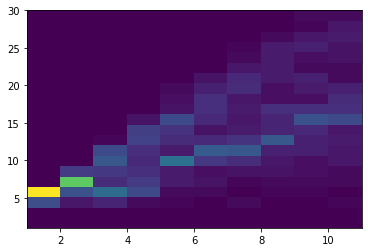

In [24]:
dataset=pandas.read_csv("datasets/protein_test_gt.csv")


draw_avg_dist_densityplot2(dataset.iloc[0:100,:],"test",30)

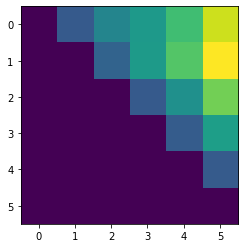

In [31]:
# demonstrate the gif_from_chips function
# which draws an animated gif of a number of chips from a saved dataset

gif_from_chips(dataset,150,"chip_slide_gif")

In [6]:
# this draws the avg distance for each pixel in all chips
# within each point in a thd dendrogram

def draw_thd_segmentations(folder,prefix,dataset):
    tda_dir="datasets/"+folder

    thds=[n for n in os.listdir(tda_dir) if n[0:len(prefix)]==prefix]
        
    df_list=[]
    names=[]
    maxes=[]
    
    for model in thds:
        
        with open(tda_dir+model) as jsonf:
            a=json.load(jsonf)
            
            df=dataset.iloc[[int(m) for m in a['rowList']],:]
            
#             print(model)
#             print([int(m) for m in a['rowList']])
            
            maxes.append(max(get_avg_distances(df)))
            df_list.append(df)
            names.append(model[len(prefix):len(model)-5])
            
    max_dist=max(maxes)
    for i in range(0,len(df_list)):
#         draw_avg_chip(df_list[i],names[i],max_dist)
#         draw_avg_dist_lineplot(df_list[i],names[i],max_dist)
#         draw_avg_dist_densityplot(df_list[i],names[i],max_dist)
        draw_avg_dist_densityplot2(df_list[i],names[i],max_dist)

def thd_row_lengths(folder,prefix):
    tda_dir="datasets/"+folder

    thds=[n for n in os.listdir(tda_dir) if n[0:len(prefix)]==prefix]
    
    d={}
    
    for model in thds:
        
        with open(tda_dir+model) as jsonf:
            a=json.load(jsonf)

            d[model]=a['meta']['row_count']
    
    for i in d:
        print(i +" "+ str(round(d[i]/max(d.values()),2)))

        

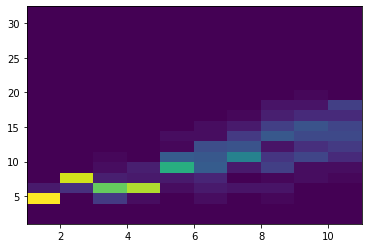

In [26]:
# demonstrate draw_thd_segmentations

# read in the dataset to use below
dataset=pandas.read_csv("datasets/protein_test_gt.csv")


draw_thd_segmentations("thd_test__Absolute Correlation_protein_test_gt_majority.csv_2019.06.18 15.51.08/","thd_test_ ",dataset)
# thd_row_lengths("thd_test__Absolute Correlation_protein_test_gt_majority.csv_2019.06.18 15.51.08/","thd_test_ ")

# draw_thd_segmentations("THD_test_Absolute Correlation_protein_test_fifteen_gt.csv_2019.06.19 14.20.55/","THD_test ",dataset)

In [ ]:
# screwing around with showing secondary structures in chart
def twod_secondary_struct(pdb_id):
    dim=length_dict[pdb_id]
    k=distance_maps_cb[pdb_id].astype(float).reshape(dim,dim)

    plt.imshow(np.triu(k))
    plt.show()

    helix=np.matrix(input_features[pdb_id][0].astype(float))
    k=np.repeat(helix,dim,0)

    plt.imshow(np.triu(np.transpose(k)*k))

In [19]:
# pdb_list_y[0].upper() + ".csv" in os.listdir("./ground_truth_cache")
protein_id=pdb_list_y[0]
pandas.read_csv(os.path.join("ground_truth_cache",(protein_id.upper() + ".csv")))


,Unnamed: 0,Model_Name,Model_ID,Chain,Residue_Name,Residue_ID,Amino_Acid,Secondary_Structure,Solvent_Accessability,Phi,Psi
0,0,12AS,0,A,ALA,4,A,-,0.896226,360.0,157.9
1,1,12AS,0,A,TYR,5,Y,H,0.090090,-41.6,-56.8
2,2,12AS,0,A,ILE,6,I,H,0.402367,-55.5,-51.1
3,3,12AS,0,A,ALA,7,A,H,0.462264,-54.4,-58.3
4,4,12AS,0,A,LYS,8,K,H,0.112195,-54.3,-39.3
5,5,12AS,0,A,GLN,9,Q,H,0.000000,-61.4,-33.5
6,6,12AS,0,A,ARG,10,R,H,0.508065,-86.1,-32.3
7,7,12AS,0,A,GLN,11,Q,H,0.227273,-52.9,-57.3
8,8,12AS,0,A,ILE,12,I,H,0.000000,-53.8,-50.5
9,9,12AS,0,A,SER,13,S,H,0.230769,-55.7,-41.7


In [54]:
distance_map_from_file(pdb_list_y[0]).shape

(256, 256)

In [1]:
max(max(chip_diagonal(10, 1, 278)[267]))

NameError: name 'chip_diagonal' is not defined

In [15]:
# raymer's idea

# each row is a pairwise comparison between 2 amino acids
# 
# 2d features will be a single column
# 1d features will be one column each per amino acid
# i.e. psisolv for AA_1, psisolv for AA_2


pdb_list, length_dict, input_features = np.load("datasets/sample-input-features.npy",allow_pickle=True)
pdb_list_y, distance_maps_cb = np.load("datasets/sample-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)


In [16]:

feat_col_names=["psipred_helix","psipred_sheet","psipred_coil","psisolv","shannon"]

cols=["protein_id","coords","sequence_distance"]
for aa in ("1","2"):
    for feature in feat_col_names:
        cols+=[feature+"_aa_"+aa]
cols+=["ccmpred","freecontact","pstat"]
cols+=["cb_dist"]

pairlist=[]

for protein_id in pdb_list:

    feat=input_features[protein_id]
    aa_length=length_dict[protein_id]

    cb_dist=distance_maps_cb[protein_id].astype(np.float)
    cb_dist.shape=(aa_length,aa_length)


    ccmpred=feat[5].astype(np.float)
    ccmpred.shape=(aa_length,aa_length)

    freecontact=feat[6].astype(np.float)
    freecontact.shape=(aa_length,aa_length)

    pstat=feat[7].astype(np.float)
    pstat.shape=(aa_length,aa_length)

    for (y,x) in [(y,x) for y in range(0,aa_length) for x in range(y+1,aa_length)]:

        row=[]
        # protein
        row.append(protein_id)

        # coords
        row.append((str(y)+"_"+str(x)))
        
        row.append(x-y)

        # 1d features
        for aa in (y,x):
            for feature in feat[0:5]:
                row.append(feature[aa].astype(np.float))

        # 2d features
        row.append(ccmpred[y,x])
        row.append(freecontact[y,x])
        row.append(pstat[y,x])
        
        row.append(cb_dist[y,x])

        pairlist.append(row)

df=pandas.DataFrame(pairlist,columns=cols)

In [19]:
dataset.iloc[0:10]

,protein_id,chip_id,starty,stopy,startx,stopx,dist_0,dist_1,dist_2,dist_3,...,solv_access_16,solv_access_17,solv_access_18,solv_access_19,solv_access_20,solv_access_21,solv_access_22,solv_access_23,solv_access_24,ss_majority_categorical
0,12asA0,chip_0,0,24,1,25,2.931498,4.466173,4.830971,5.929355,...,0.076923,0.524194,0.080808,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,H
1,12asA0,chip_1,10,34,11,35,3.038332,4.728816,4.798806,5.939553,...,0.524194,0.080808,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,H
2,12asA0,chip_2,20,44,21,45,3.220644,4.942284,4.694743,4.624504,...,0.080808,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,None
3,12asA0,chip_3,30,54,31,55,3.084223,6.574061,7.992070,11.165921,...,0.018293,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,None
4,12asA0,chip_4,40,64,41,65,3.353860,6.414218,9.307878,11.852681,...,0.396907,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,None
5,12asA0,chip_5,50,74,51,75,3.025968,5.983908,9.169363,12.412947,...,0.644330,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,None
6,12asA0,chip_6,60,84,61,85,3.465978,6.825651,10.210162,13.602541,...,0.463710,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,None
7,12asA0,chip_7,70,94,71,95,3.301132,5.084345,5.704537,7.120590,...,0.121951,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,0.110294,None
8,12asA0,chip_8,80,104,81,105,2.976071,5.697506,8.974933,12.012601,...,0.476190,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,0.110294,0.053254,None
9,12asA0,chip_9,90,114,91,115,3.198181,5.837018,9.110159,12.486529,...,0.024390,0.201183,0.262887,0.014085,0.136364,0.103774,0.110294,0.053254,0.103659,None
